# NLP Project
Quora Question Pairs


Input the dataset:
There have two dataset train data and test data.

In [83]:
import numpy as np 
import pandas as pd 


train_df = pd.read_csv("train.csv")
train_df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [84]:
test_df = pd.read_csv("test.csv")
test_df.head(10)

/scratch/local/ipykernel_25779/3092447787.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("test.csv")


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?


Improt all the libaries that we will need in this project

In [51]:
import torch
import torch.nn as nn

# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install tqdm
from tqdm import tqdm


from sklearn.model_selection import train_test_split

# !pip install -c conda-forge transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
transformers.logging.set_verbosity_error()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 1024

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


# Data Analysis

## Sentence length setect
Do some analsis and remove some of the missing values, because the data is text. Then check the length of the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<Axes: ylabel='Count'>

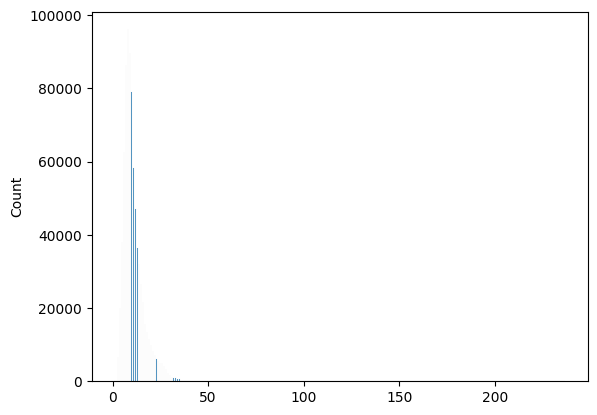

In [52]:
train_df.info()

train_df.dropna(inplace=True)
train_sentences_lens = train_df['question1'].apply(lambda x: len(x.split(' '))).tolist()
train_sentences_lens.extend(train_df['question2'].apply(lambda x: len(x.split(' '))).tolist())
sns.histplot(train_sentences_lens)


From the graph you can see that most the data are all under 50 words in every sentence.

So we can set 50 as the maximun lenth of the sentence.

In [53]:
MaximunLen = 50

## Number of the sentences
Let see how many different questions are in the data

In [54]:
qids = pd.Series(list(train_df['question1']) + list(train_df['question2']))

print ('Unique Questions number: {}\n'.format(len(np.unique(qids))))


Unique Questions number: 537359



## Analysis the duplicate and similar
Let see the percentage of duplicate and similar in the train data by analysis the duplicate in the train data.

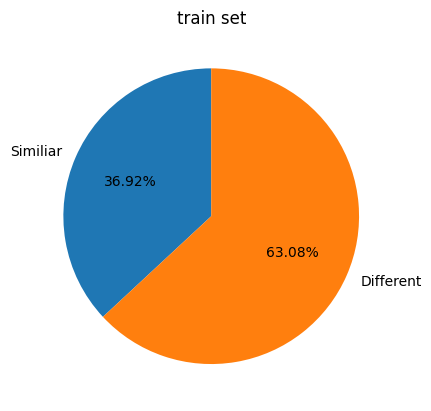

In [55]:
def pie_chart(similar_questions_num, different_questions_num, graph_title):
    labels = 'Similiar', 'Different'
    sizes = [similar_questions_num, different_questions_num]

    fig1, ax1 = plt.subplots()
    ax1.set_title(graph_title)
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

    plt.show()

similar_samples_num = sum(train_df['is_duplicate'].values)
pie_chart(similar_samples_num, len(train_df['is_duplicate']) - similar_samples_num, 'train set')

## Same sentence detect
Let see if there's any paired quesions that are exacte the same.

In [56]:
duplicate_rows = train_df[train_df.duplicated(['qid1','qid2'])]
print ("Number of duplicate questions : ", len(duplicate_rows))

Number of duplicate questions :  0


## Shared words detect
Let analysis if there's shared words in both question1 and question2.

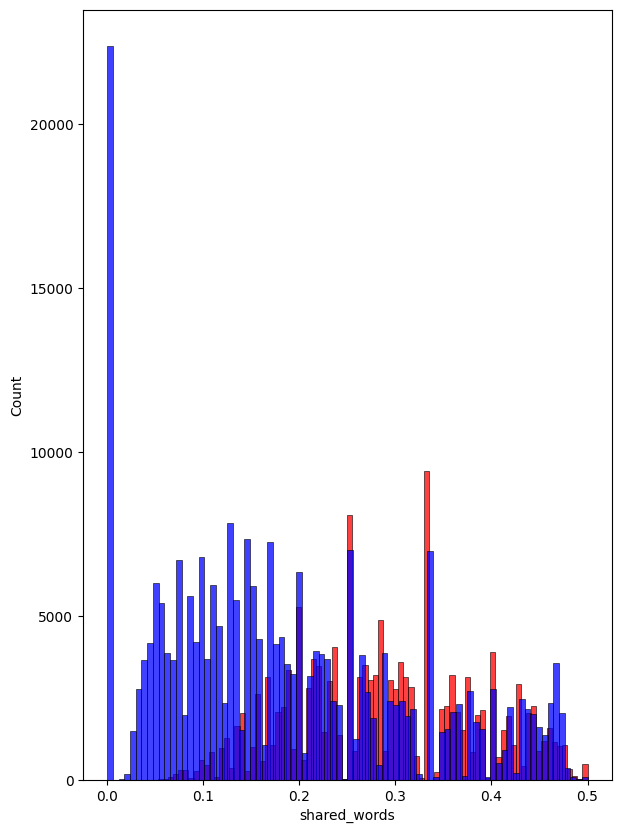

In [57]:
def shared_words(row):
    q1_word_set = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2_word_set = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(q1_word_set & q2_word_set) / (len(q1_word_set) + len(q2_word_set))    

train_df['shared_words'] = train_df.apply(shared_words, axis=1)
plt.figure(figsize=(15, 10))

plt.subplot(1,2,2)
sns.histplot(train_df[train_df['is_duplicate'] == 1]['shared_words'][0:] , label = "1", color = 'red')
sns.histplot(train_df[train_df['is_duplicate'] == 0]['shared_words'][0:] , label = "0" , color = 'blue' )


plt.show()

It seems that both question1 and question2 have shared words in the questions.

## load pretrain module
Let load the pretrain module and splite the data to training data and validation

In [58]:
BERT_VERSION = 'bert-base-uncased'
POOLED_OUTPUT_DIM = 768 
tokenizer = BertTokenizer.from_pretrained(BERT_VERSION)

train_df, val_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Make a class easier to load the pretrain model. For the pretrain model we tokenize every sentence using the tokenizer(BertTokenizer.from_pretrained(bert-base-uncased)) and return a dictionary containing the input IDs, attention mask, token type IDs, and the target label.
Using "torch.utils.data.DataLoader" with the batch size and shuffle setting.

In [59]:
class BertDataSet:
    def __init__(self, questions1, questions2, targets, tokenizer):
        self.questions1 = questions1
        self.questions2 = questions2
        self.targets = targets
        self.tokenizer = tokenizer
        self.length = len(questions1)
        
    def __len__(self):
        return self.length

    def __getitem__(self, item):
        questions1 = str(self.questions1[item])
        questions2 = str(self.questions2[item])

        questions1 = " ".join(questions1.split())
        questions2 = " ".join(questions2.split())

        
        inputs = self.tokenizer.encode_plus(
            questions1,
            questions2,
            add_special_tokens=True,
            padding='max_length',
            max_length=2 * MaximunLen + 3, # max length of 2 questions and 3 special tokens
            truncation=True   
        )
        
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets": torch.tensor(int(self.targets[item]), dtype=torch.long) if self.targets is not None else 0
        }

def get_data_loader(dataset, targets, batch_size, shuffle, tokenizer):
    dataset = BertDataSet(
        questions1=dataset["question1"].values,
        questions2=dataset["question2"].values,
        targets=targets,
        tokenizer=tokenizer
    )

    # print(dataset)
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle
    )
    
    return data_loader

batchsize = 256

train_data_loader = get_data_loader(
    dataset=train_df,
    targets=train_df["is_duplicate"].values,
    batch_size=batchsize,
    shuffle=True,
    tokenizer=tokenizer
)

val_data_loader = get_data_loader(
    dataset=val_df,
    targets=val_df["is_duplicate"].values,
    batch_size=4 * batchsize,
    shuffle=True,
    tokenizer=tokenizer
)


In [60]:
# Print a batch of data from the training data loader
for batch in train_data_loader:
    print("Batch data:")
    print("Input IDs:", batch["ids"])
    print("Attention Mask:", batch["mask"])
    print("Token Type IDs:", batch["token_type_ids"])
    print("Targets:", batch["targets"])
    break  # Print only the first batch for brevity

# Print a batch of data from the validation data loader
for batch in val_data_loader:
    print("Batch data:")
    print("Input IDs:", batch["ids"])
    print("Attention Mask:", batch["mask"])
    print("Token Type IDs:", batch["token_type_ids"])
    print("Targets:", batch["targets"])
    break  # Print only the first batch for brevity


Batch data:
Input IDs: tensor([[  101,  1045,  2215,  ...,     0,     0,     0],
        [  101,  2339,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2079,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2079,  ...,     0,     0,     0],
        [  101,  2129,  2097,  ...,     0,     0,     0],
        [  101, 22817, 14181,  ...,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Token Type IDs: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Targets: tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,

## Bert trainning model
I make a class for the trainning model. The model is still bert-base-uncased.
In the trainning I calculate the validation from the function "calculate_perplexity". And calculate the trainning loss in the "train_loop". 
I traing with 5 epoch and Learning Rate(lr) is 3e-5 and the batch is depend on the data, it'll be 1422 in this case.

In [69]:
class BertModel(nn.Module):
    def __init__(self, bert_path):
        super(BertModel, self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.BertModel.from_pretrained(self.bert_path)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(POOLED_OUTPUT_DIM, 1)

    def forward(self, ids, mask, token_type_ids):
        _, pooled = self.bert(ids, attention_mask=mask,token_type_ids=token_type_ids,return_dict=False)
        
        # add dropout to prevent overfitting.
        pooled = self.dropout(pooled) 
        return self.out(pooled)

model = BertModel(BERT_VERSION).to(device)

def loss_fn(outputs, targets):
    outputs = torch.squeeze(outputs)
    return nn.BCELoss()(nn.Sigmoid()(outputs), targets)


def calculate_perplexity(data_loader, model, device):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        for batch in data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            total_loss += loss_fn(outputs, targets).item()
                   

    model.train()

    return np.exp(total_loss / len(data_loader))


In [65]:
def train_loop(epochs, train_data_loader, val_data_loader, model, optimizer, device, scheduler=None):
    it = 1
    total_loss = 0
    curr_perplexity = None
    perplexity = None
    
    model.train()
    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        for batch in train_data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            optimizer.zero_grad()
            
            outputs = model(ids, mask=mask, token_type_ids=token_type_ids)
            
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            
            loss.backward()
            
            optimizer.step()
           
            if it % 100 == 0:
            
                if it % 100 == 0:
                    curr_perplexity = calculate_perplexity(val_data_loader, model, device)
                    
                    if scheduler is not None:
                        scheduler.step()
                        
                    if not perplexity or curr_perplexity < perplexity:
                        torch.save(model.state_dict(), 'uncased_model')
                        perplexity = curr_perplexity
                        
                avg_train_loss = total_loss / 100
                print('| Iter', it, '| Avg Train Loss', avg_train_loss, '| Dev Perplexity', curr_perplexity)
                total_loss = 0
                
            it += 1


In [66]:
def run(model, train_df, device, train_data_loader, val_data_loader):
    EPOCHS = 5
    
    lr = 3e-5
    num_training_steps = int(len(train_data_loader) * EPOCHS)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    
    train_loop(EPOCHS, train_data_loader, val_data_loader,  model, optimizer, device, scheduler)

In [ ]:
run(model, train_df, device, train_data_loader, val_data_loader)

Epoch:  1
| Iter 100 | Avg Train Loss 0.36829567819833753 | Dev Perplexity 1.4120122640005845
| Iter 200 | Avg Train Loss 0.3381352695822716 | Dev Perplexity 1.3721972345022608
| Iter 300 | Avg Train Loss 0.3211359757184982 | Dev Perplexity 1.3528421891209148
| Iter 400 | Avg Train Loss 0.30819258719682696 | Dev Perplexity 1.348373891179349
| Iter 500 | Avg Train Loss 0.2963800723850727 | Dev Perplexity 1.3360203537585158
| Iter 600 | Avg Train Loss 0.2925376646220684 | Dev Perplexity 1.3239872664429344
| Iter 700 | Avg Train Loss 0.2911820366978645 | Dev Perplexity 1.314145187190489
| Iter 800 | Avg Train Loss 0.27900337100028993 | Dev Perplexity 1.3095773829700192
| Iter 900 | Avg Train Loss 0.2798917533457279 | Dev Perplexity 1.306145566351985
| Iter 1000 | Avg Train Loss 0.270376580953598 | Dev Perplexity 1.2979141196432822
| Iter 1100 | Avg Train Loss 0.27087289914488794 | Dev Perplexity 1.2886162475338117
| Iter 1200 | Avg Train Loss 0.26712505251169205 | Dev Perplexity 1.2872292

You can see the result look fine that the Loss decrease to 0.070.

## Prediction of the test dataset
Make a test function try to detect the prediction and see how's my model's performance.
For testing the performance I use batch size as 512.
And I use sigmoid to show the result of my prediction.
So the result will be the number between 0 and 1. 
If the result close to 1 means that the question1 and question2 are more similar.
And I save the result into the result.csv file.
I print out head 100 result to see how's the result.

In [135]:
def test(model, test_df, device):
    
    # Instantiate the model
    model = BertModel(BERT_VERSION).to(device)

    # Load the state dictionary
    model.load_state_dict(torch.load('uncased_model'))
    
    predictions = torch.empty(0).to(device, dtype=torch.float)
    
    test_dataset = BertDataSet(
        questions1=test_df["question1"].values,
        questions2=test_df["question2"].values,
        targets=None,
        tokenizer=tokenizer
    )
    
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=512
    )
    
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_data_loader):
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            predictions = torch.cat((predictions, nn.Sigmoid()(outputs)))
    
    return predictions.cpu().numpy().squeeze()

predictions = test('uncased_model', test_df, device)
len(predictions)

100%|██████████| 6960/6960 [1:07:25<00:00,  1.72it/s]


3563475

In [138]:
test_df['is_duplicate'] = predictions

test_df[['test_id','question1', 'question2', 'is_duplicate']].to_csv('./result.csv', index=False)

data = pd.read_csv("result.csv")
data.head(100)

/scratch/local/ipykernel_25779/4139269262.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("result.csv")


,test_id,question1,question2,is_duplicate
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0.010535
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0.650432
2,2,What but is the best way to send money from Ch...,What you send money to China?,0.018178
3,3,Which food not emulsifiers?,What foods fibre?,0.004047
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,0.020853
...,...,...,...,...
95,95,What does it mean when my husband looks at oth...,What should I do when my husband looks for oth...,0.062463
96,96,For which exam a graduate electrical student s...,What are some criteria to be called ILLEGAL im...,0.000357
97,97,How we can earn not easily?,How can I get genuine money easily?,0.869894
98,98,What are the to different symbols used by The ...,What does the nothing symbol mean ➰?,0.000721


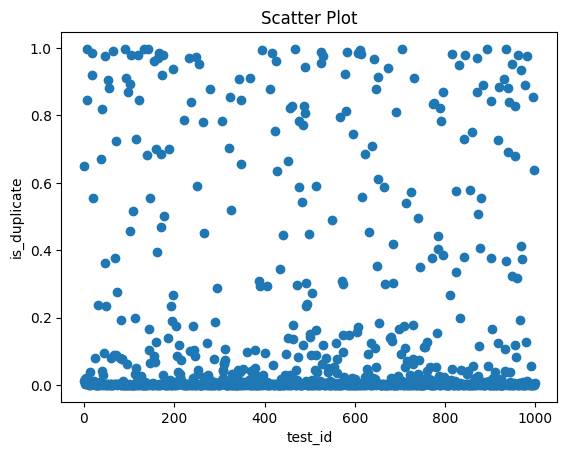

In [166]:
# print(data.head())
x_column = 'test_id'
y_column = 'is_duplicate'
resultID = data[x_column][0:1000]
resultIS_duplicate = data[y_column][0:1000]
plt.scatter(x=resultID, y=resultIS_duplicate)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('Scatter Plot')
plt.show()

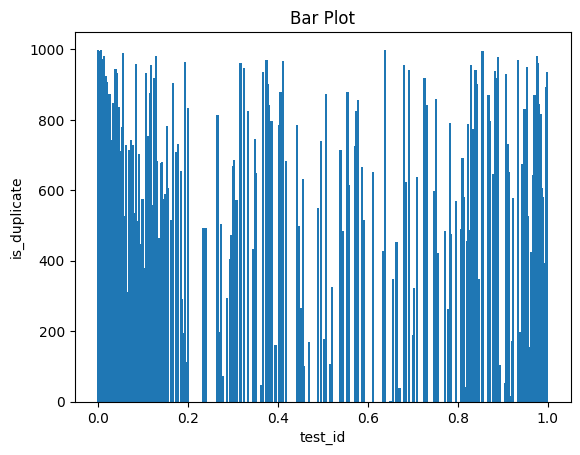

In [167]:
plt.bar(resultIS_duplicate, resultID, width =0.005)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('Bar Plot')
plt.show()